In [2]:
pip install google.colab

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import requests
from tqdm import tqdm
from io import StringIO
# from google.colab import files

# Coordinates for Punjab (Lahore area)
latitude = 31.1704
longitude = 72.7097
    
# Updated parameters to ensure we get precipitation
parameters = "T2M_MAX,T2M_MIN,PRECTOTCORR,RH2M"  # Using corrected precipitation

# Optimized date chunks
year_chunks = [
    ("20000115", "20000315"),
    ("20010115", "20010315"),
    ("20020115", "20020315"),
    ("20030115", "20030315"),
    ("20040115", "20040315"),
    ("20050115", "20050315"),
    ("20060115", "20060315"),
    ("20070101", "20071231"),
    ("20080101", "20081231"),
    ("20090101", "20091231"),
    ("20100101", "20100315"),
    ("20110115", "20110315"),
    ("20120115", "20120315"),
    ("20130101", "20131231"),
    ("20140101", "20141231"),
    ("20150101", "20151231"),
    ("20160101", "20160315"),
    ("20170115", "20170315"),
    ("20180101", "20181231"),
    ("20190101", "20191231"),
    ("20200101", "20201231"),
    ("20210101", "20210315"),
    ("20220101", "20221231"),
    ("20230101", "20230315"),
]


all_data = []

for start, end in tqdm(year_chunks, desc="Downloading data"):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": parameters,
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "start": start,
        "end": end,
        "format": "CSV"
    }

    try:
        response = requests.get(url, params=params, timeout=30)
        if response.status_code == 200:
            # Find data start line more robustly
            lines = [line.strip() for line in response.text.split('\n') if line.strip()]
            header_line = next(i for i, line in enumerate(lines)
                             if line.startswith(('YEAR', 'YYYYMMDD')))

            # Read data with proper headers
            chunk_df = pd.read_csv(StringIO('\n'.join(lines[header_line:])),
                                 skiprows=0)

            # Clean column names
            chunk_df.columns = [col.split('(')[0].strip().upper() for col in chunk_df.columns]
            all_data.append(chunk_df)
        else:
            print(f"Failed for {start}-{end}: Status {response.status_code}")
    except Exception as e:
        print(f"Error for {start}-{end}: {str(e)}")

if not all_data:
    raise ValueError("No data was downloaded - please check parameters")

# Combine all data
full_df = pd.concat(all_data)

# Standardize columns - handle different API versions
column_mapping = {
    'T2M_MAX': 'Max_Temp_C',
    'T2M_MIN': 'Min_Temp_C',
    'PRECTOTCORR': 'Precipitation_mm',
    'RH2M': 'Humidity_pct',
    'YEAR': 'Year',
    'DOY': 'Day_of_Year',
    'YYYYMMDD': 'Date_Number'
}

# Rename columns
full_df = full_df.rename(columns={k.upper(): v for k, v in column_mapping.items()
                                if k.upper() in full_df.columns})

# Create proper Date column
if 'Year' in full_df.columns and 'Day_of_Year' in full_df.columns:
    full_df['Date'] = pd.to_datetime(
        full_df['Year'].astype(str) + '-' +
        full_df['Day_of_Year'].astype(str),
        format='%Y-%j'
    )
elif 'Date_Number' in full_df.columns:
    full_df['Date'] = pd.to_datetime(full_df['Date_Number'], format='%Y%m%d')

# Select and order our desired columns
final_columns = [
    'Date',
    'Max_Temp_C',
    'Min_Temp_C',
    'Precipitation_mm',
    'Humidity_pct'
]

# Ensure we only keep columns that exist
final_df = full_df[[col for col in final_columns if col in full_df.columns]]

# Fill any missing precipitation with 0 (assuming no rain)
if 'Precipitation_mm' in final_df.columns:
    final_df['Precipitation_mm'] = final_df['Precipitation_mm'].fillna(0)

# Save and download
output_filename = 'punjab_weather_2000_2023_complete.csv'
final_df.to_csv(output_filename, index=False)
files.download(output_filename)

print("\nFinal data preview:")
print(final_df.head())
print("\nColumns in final data:", final_df.columns.tolist())
print("\nDate range:", final_df['Date'].min(), "to", final_df['Date'].max())

/tmp/ipykernel_135057/3157001025.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Precipitation_mm'] = final_df['Precipitation_mm'].fillna(0)


NameError: name 'files' is not defined

In [ ]:
import pandas as pd

# Load the uploaded CSV files
weather_file_path = '/content/punjab_weather_2000_2023_complete.csv'
vegetation_file_path = '/content/yield.csv'

# Read the CSV files
weather_data = pd.read_csv(weather_file_path)
vegetation_data = pd.read_csv(vegetation_file_path)

weather_data.head(), vegetation_data.head()


(         Date  Max_Temp_C  Min_Temp_C  Precipitation_mm  Humidity_pct
 0  2000-01-15       16.50        0.99               0.0         54.15
 1  2000-01-16       17.53        2.62               0.0         42.17
 2  2000-01-17       19.34        2.53               0.0         37.95
 3  2000-01-18       22.66        5.64               0.0         33.98
 4  2000-01-19       23.38        7.11               0.0         35.59,
    YEAR  (kg/acre)    NDVI    NDMI   MSAVI
 0  2000     1079.2  0.4655  0.1908  0.2897
 1  2001      997.6  0.4415  0.1640  0.2671
 2  2002      968.0  0.3875  0.1491  0.2287
 3  2003     1019.2  0.4668  0.2154  0.3035
 4  2004     1011.6  0.5297  0.2471  0.3287)

In [ ]:
import pandas as pd

# 1. LOAD your CSV file
weather_df = pd.read_csv('/content/punjab_weather_2000_2023_complete.csv', parse_dates=['Date'])

# 2. EXTRACT 'Year' from 'Date'
weather_df['Year'] = weather_df['Date'].dt.year

# 3. FILTER only Jan 15 to Mar 15
weather_df = weather_df[
    ((weather_df['Date'].dt.month == 1) & (weather_df['Date'].dt.day >= 15)) |
    (weather_df['Date'].dt.month == 2) |
    ((weather_df['Date'].dt.month == 3) & (weather_df['Date'].dt.day <= 15))
]

# 4. GROUP BY Year and CALCULATE Mean
weather_summary = weather_df.groupby('Year').agg({
    'Max_Temp_C': 'mean',
    'Min_Temp_C': 'mean',
    'Precipitation_mm': 'mean',
    'Humidity_pct': 'mean'
}).reset_index()

# 5. RENAME columns nicely
weather_summary = weather_summary.rename(columns={
    'Max_Temp_C': 'tempmax',
    'Min_Temp_C': 'tempmin',
    'Precipitation_mm': 'precip',
    'Humidity_pct': 'humidity'
})

# 6. ROUND values (optional, looks cleaner)
weather_summary = weather_summary.round(2)

# 7. SAVE to CSV (optional)
weather_summary.to_csv('punjab_weather_mean_2000_2023.csv', index=False)

print("✅ Weather yearly means calculated!")
print(weather_summary)


✅ Weather yearly means calculated!
    Year  tempmax  tempmin  precip  humidity
0   2000    24.04     7.32    0.25     38.02
1   2001    26.29     8.57    0.01     28.80
2   2002    24.92     8.85    0.54     33.57
3   2003    25.08     9.47    0.61     39.99
4   2004    27.16    11.02    0.26     35.82
5   2005    22.35     8.67    0.85     52.80
6   2006    27.49    11.76    0.25     35.76
7   2007    23.69     9.28    1.50     53.06
8   2008    24.94     8.28    0.24     30.94
9   2009    26.49    10.28    0.38     40.53
10  2010    26.59    10.39    0.44     34.03
11  2011    24.52     8.98    0.28     40.57
12  2012    23.18     6.71    0.15     33.46
13  2013    24.41     8.97    1.20     43.71
14  2014    24.17     8.95    0.18     37.45
15  2015    23.35     9.06    1.48     49.56
16  2016    25.95    10.44    0.62     33.36
17  2017    24.66     9.44    0.64     42.57
18  2018    26.77    10.30    0.27     33.86
19  2019    21.55     7.55    0.96     51.74
20  2020    23.27   

In [ ]:
# import pandas as pd

# 1. Load files
weather = pd.read_csv('/content/punjab_weather_mean_2000_2023.csv')
yield_data = pd.read_csv('/content/yield.csv')

# 2. Clean column names
yield_data.columns = yield_data.columns.str.strip()  # remove extra spaces
yield_data.rename(columns={'YEAR': 'Year', '(kg/acre)': 'kg_per_acre'}, inplace=True)  # fix names

# 3. Merge
final_data = pd.merge(weather, yield_data, on='Year')

# 4. Save
final_data.to_csv('final_merged_weather_yield.csv', index=False)

print("✅ Done! Here's preview:")
print(final_data)


✅ Done! Here's preview:
    Year  tempmax  tempmin  precip  humidity  kg_per_acre    NDVI    NDMI  \
0   2000    24.04     7.32    0.25     38.02       1079.2  0.4655  0.1908   
1   2001    26.29     8.57    0.01     28.80        997.6  0.4415  0.1640   
2   2002    24.92     8.85    0.54     33.57        968.0  0.3875  0.1491   
3   2003    25.08     9.47    0.61     39.99       1019.2  0.4668  0.2154   
4   2004    27.16    11.02    0.26     35.82       1011.6  0.5297  0.2471   
5   2005    22.35     8.67    0.85     52.80       1102.4  0.4899  0.2328   
6   2006    27.49    11.76    0.25     35.76       1047.2  0.5243  0.2443   
7   2007    23.69     9.28    1.50     53.06       1123.2  0.5631  0.2730   
8   2008    24.94     8.28    0.24     30.94        986.4  0.4628  0.1917   
9   2009    26.49    10.28    0.38     40.53       1090.4  0.5671  0.2684   
10  2010    26.59    10.39    0.44     34.03       1048.8  0.5071  0.2286   
11  2011    24.52     8.98    0.28     40.57       1

   Year  tempmax  tempmin  precip  humidity  kg_per_acre    NDVI    NDMI  \
0  2000    24.04     7.32    0.25     38.02       1079.2  0.4655  0.1908   
1  2001    26.29     8.57    0.01     28.80        997.6  0.4415  0.1640   
2  2002    24.92     8.85    0.54     33.57        968.0  0.3875  0.1491   
3  2003    25.08     9.47    0.61     39.99       1019.2  0.4668  0.2154   
4  2004    27.16    11.02    0.26     35.82       1011.6  0.5297  0.2471   

    MSAVI  
0  0.2897  
1  0.2671  
2  0.2287  
3  0.3035  
4  0.3287  


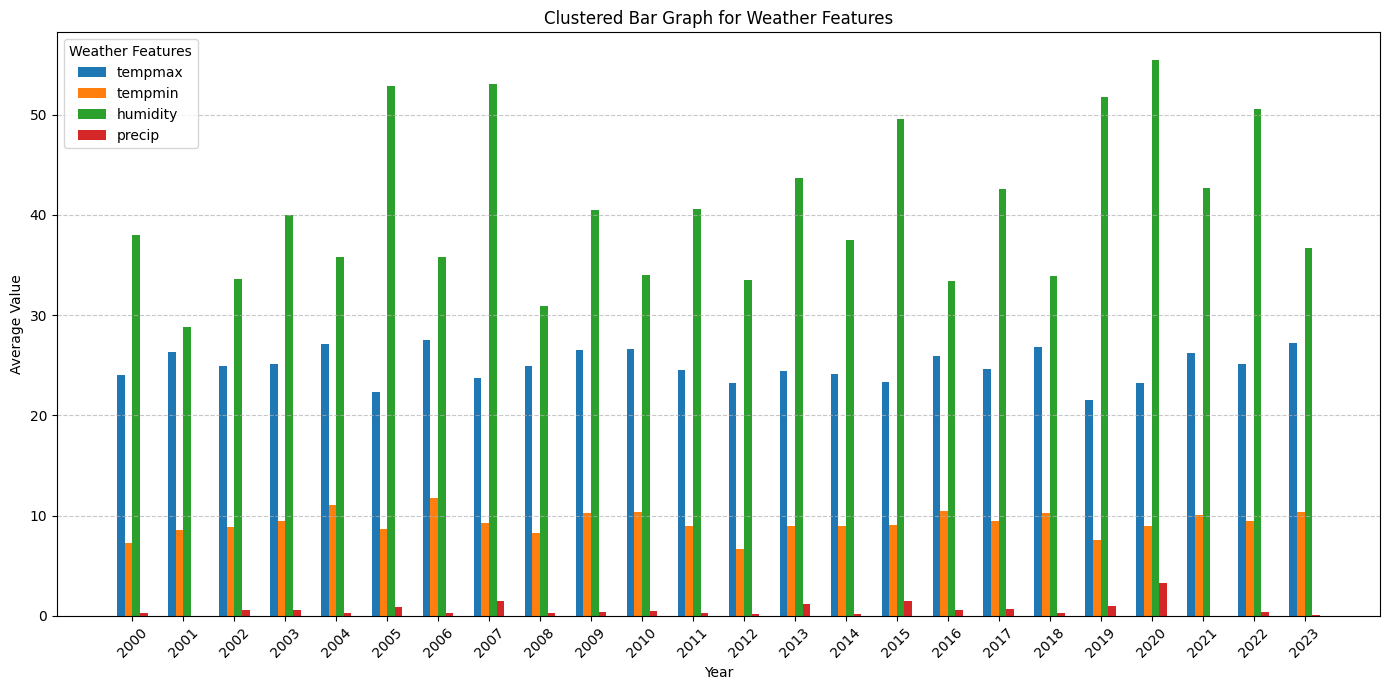

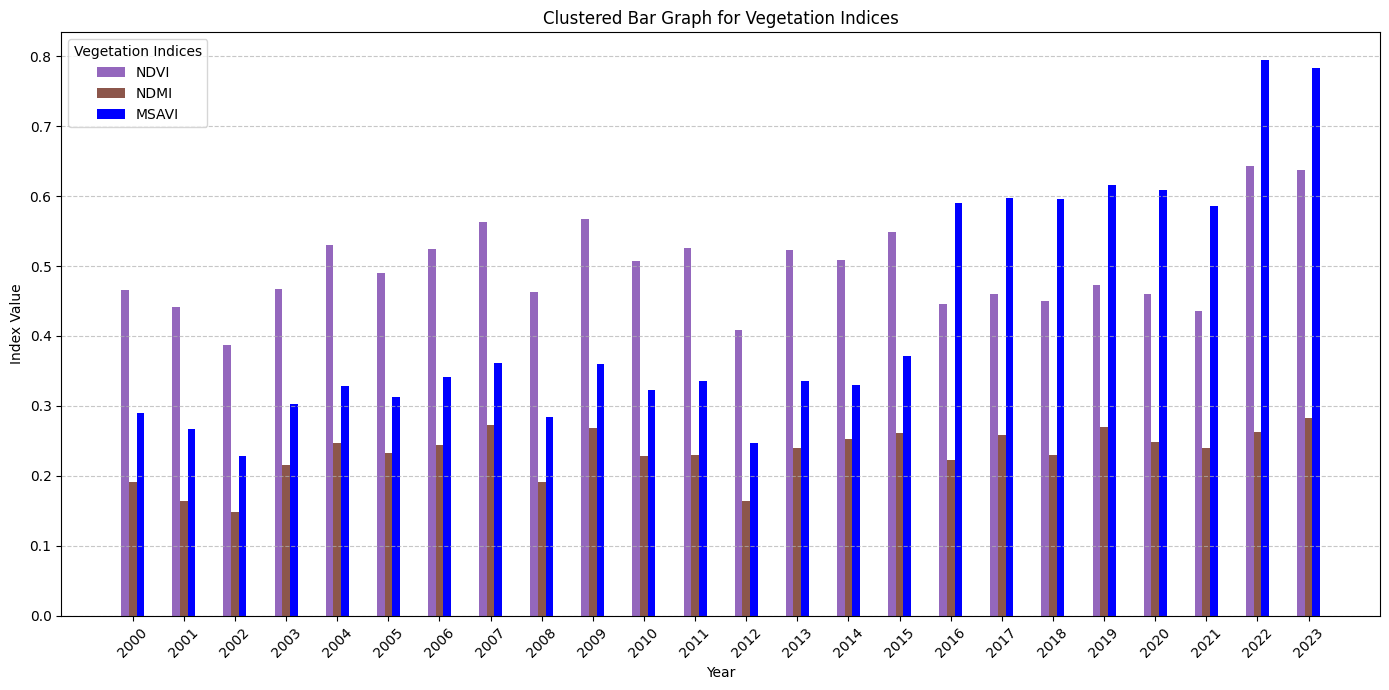

Weather Features Mean:
tempmax     24.977917
tempmin      9.297500
humidity    40.626250
precip       0.623333
dtype: float64

Vegetation Indices Mean:
NDVI     0.496779
NDMI     0.231992
MSAVI    0.424517
dtype: float64
           tempmax   tempmin  humidity    precip      NDVI      NDMI     MSAVI
tempmax   1.000000  0.790373 -0.630939 -0.501509  0.204392  0.010319  0.112568
tempmin   0.790373  1.000000 -0.156248 -0.124901  0.378772  0.444323  0.269409
humidity -0.630939 -0.156248  1.000000  0.702551  0.343501  0.604061  0.349354
precip   -0.501509 -0.124901  0.702551  1.000000  0.007897  0.291378  0.155253
NDVI      0.204392  0.378772  0.343501  0.007897  1.000000  0.725826  0.378541
NDMI      0.010319  0.444323  0.604061  0.291378  0.725826  1.000000  0.590147
MSAVI     0.112568  0.269409  0.349354  0.155253  0.378541  0.590147  1.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the merged dataset
merged_data = pd.read_csv('/content/final_merged_weather_yield.csv')

# Display the first few rows of the dataset to check its structure
print(merged_data.head())

# List of weather features to plot
weather_features = ['tempmax', 'tempmin', 'humidity', 'precip']

# Create x-axis labels and define the width of the bars
x = np.arange(len(merged_data['Year']))  # Label locations
width = 0.15  # Width of the bars

# Plot the weather features as clustered bar graphs
fig, ax = plt.subplots(figsize=(14, 7))  # Increased figure size

# Create bars for each feature
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Different colors for each feature
for i, (feature, color) in enumerate(zip(weather_features, colors)):
    ax.bar(x + i * width, merged_data[feature], width, label=feature, color=color)

# Customize the plot
ax.set_xlabel('Year')
ax.set_ylabel('Average Value')
ax.set_title('Clustered Bar Graph for Weather Features')
ax.set_xticks(x + width * (len(weather_features) - 1) / 2)
ax.set_xticklabels(merged_data['Year'], rotation=45)  # Rotate x-axis labels
ax.legend(title='Weather Features')
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines

plt.tight_layout()
plt.show()

# List of vegetation indices to plot
vegetation_indices = ['NDVI', 'NDMI','MSAVI']

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(14, 7))  # Increased figure size

# Plot the vegetation indices
colors = ['#9467bd', '#8c564b','BLUE']  # Different colors for each index
for i, (index, color) in enumerate(zip(vegetation_indices, colors)):
    ax.bar(x + i * width, merged_data[index], width, label=index, color=color)

# Add labels, title, and legend
ax.set_xlabel('Year')
ax.set_ylabel('Index Value')
ax.set_title('Clustered Bar Graph for Vegetation Indices')
ax.set_xticks(x + width * (len(vegetation_indices) - 1) / 2)
ax.set_xticklabels(merged_data['Year'], rotation=45)  # Rotate x-axis labels
ax.legend(title='Vegetation Indices')
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines

plt.tight_layout()
plt.show()

# Calculate the mean of each feature (weather and vegetation indices)
weather_means = merged_data[weather_features].mean()
vegetation_means = merged_data[vegetation_indices].mean()

# Print the means
print("Weather Features Mean:")
print(weather_means)
print("\nVegetation Indices Mean:")
print(vegetation_means)

# Calculate correlation between weather features and vegetation indices
correlation = merged_data[weather_features + vegetation_indices].corr()

# Display the correlation matrix
print(correlation)

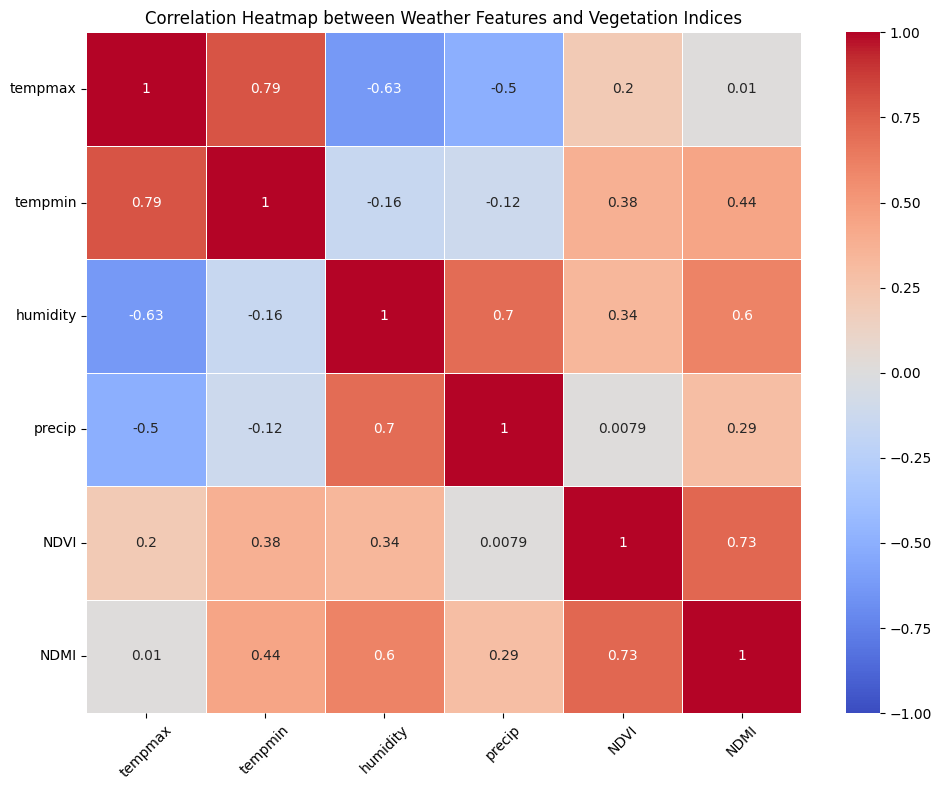

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
merged_data = pd.read_csv('/content/final_merged_weather_yield.csv')

# Define the weather features and vegetation indices
weather_features = ['tempmax', 'tempmin', 'humidity', 'precip']
vegetation_indices = ['NDVI', 'NDMI']

# Calculate the correlation matrix
correlation = merged_data[weather_features + vegetation_indices].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Customize the plot
plt.title('Correlation Heatmap between Weather Features and Vegetation Indices')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

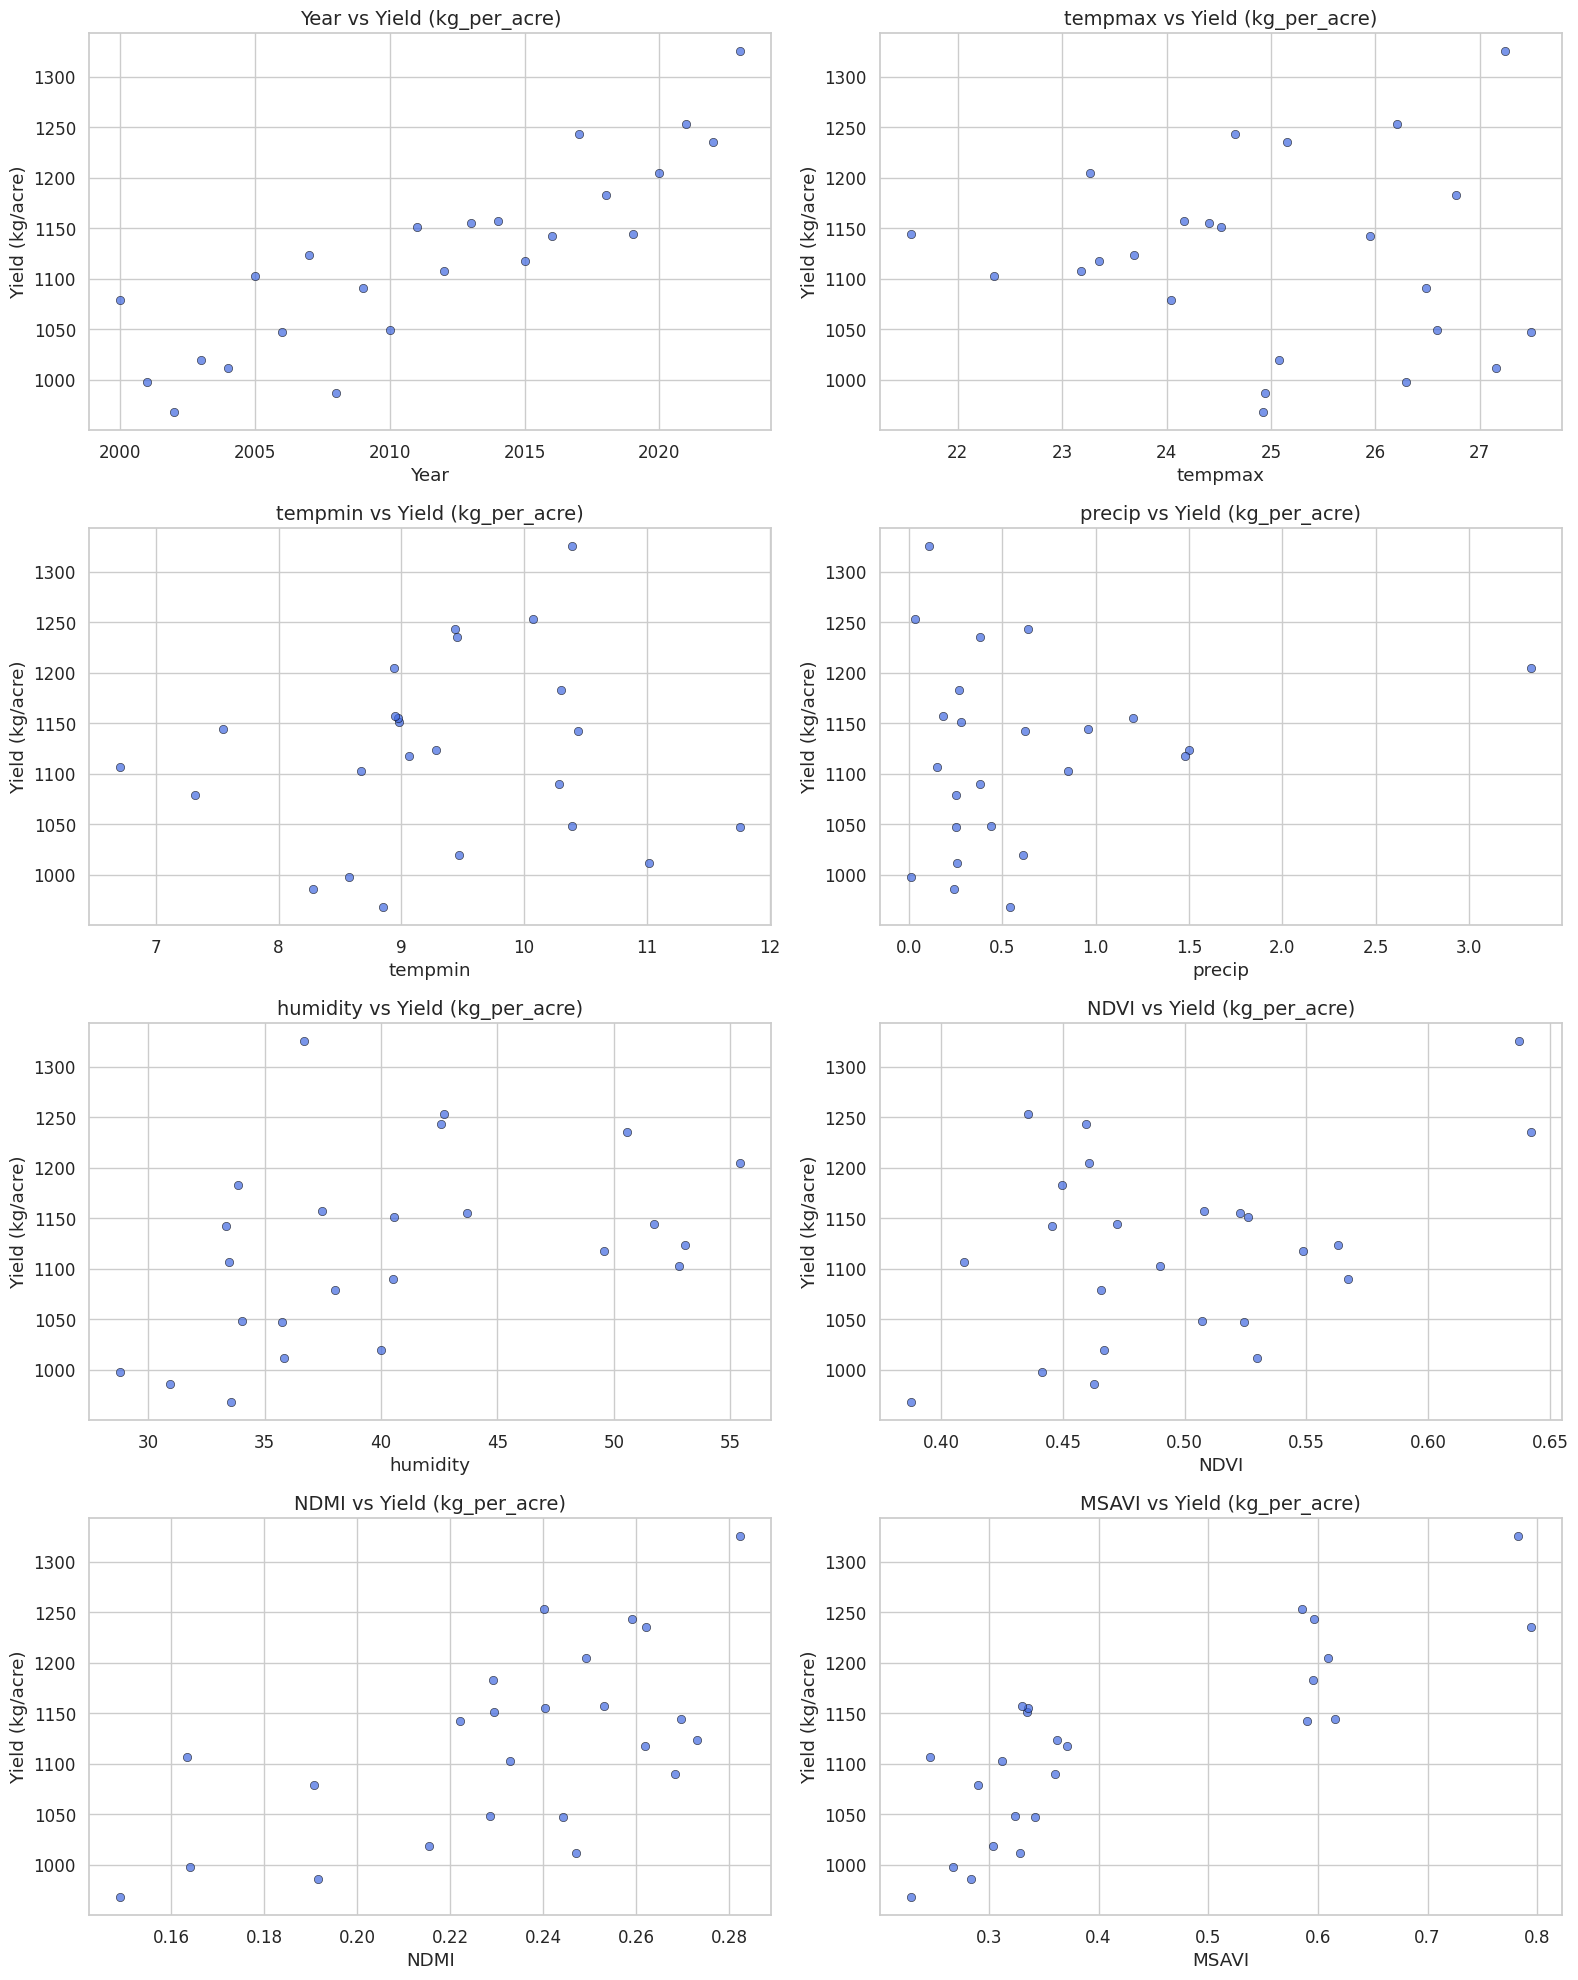

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
merged_data = pd.read_csv('/content/final_merged_weather_yield.csv')

# List of features to plot against kg_per_acre
features = ['Year', 'tempmax', 'tempmin', 'precip', 'humidity', 'NDVI', 'NDMI', 'MSAVI']

# Set Seaborn style
sns.set(style='whitegrid', font_scale=1.1)

# Create subplots: 4 rows, 2 columns
fig, axs = plt.subplots(4, 2, figsize=(16, 20))

# Flatten the axs array
axs = axs.flatten()

# Loop through features and plot
for i, feature in enumerate(features):
    sns.scatterplot(data=merged_data, x=feature, y='kg_per_acre', ax=axs[i], color='royalblue', edgecolor='black', alpha=0.7)
    axs[i].set_title(f'{feature} vs Yield (kg_per_acre)', fontsize=14)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Yield (kg/acre)')

plt.tight_layout()
plt.show()

# Loop through features and plot with regression line
for i, feature in enumerate(features):
    sns.regplot(data=merged_data, x=feature, y='kg_per_acre', ax=axs[i],
                scatter_kws={'s':40, 'alpha':0.6}, line_kws={'color':'red'})
    axs[i].set_title(f'{feature} vs Yield (kg_per_acre)', fontsize=14)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Yield (kg/acre)')



<ipython-input-11-dce4a209588a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')


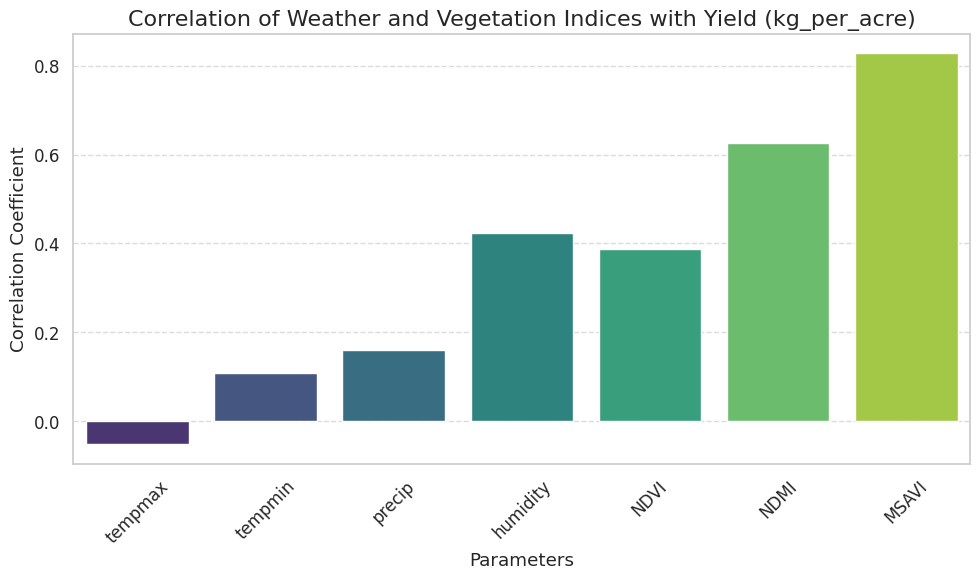

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming it's already loaded)
merged_data = pd.read_csv('/content/final_merged_weather_yield.csv')

# Select the features to check
features = ['tempmax', 'tempmin', 'precip', 'humidity', 'NDVI', 'NDMI', 'MSAVI']

# Calculate correlation with yield
correlations = merged_data[features + ['kg_per_acre']].corr()['kg_per_acre'].drop('kg_per_acre')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')
plt.title('Correlation of Weather and Vegetation Indices with Yield (kg_per_acre)', fontsize=16)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Parameters')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


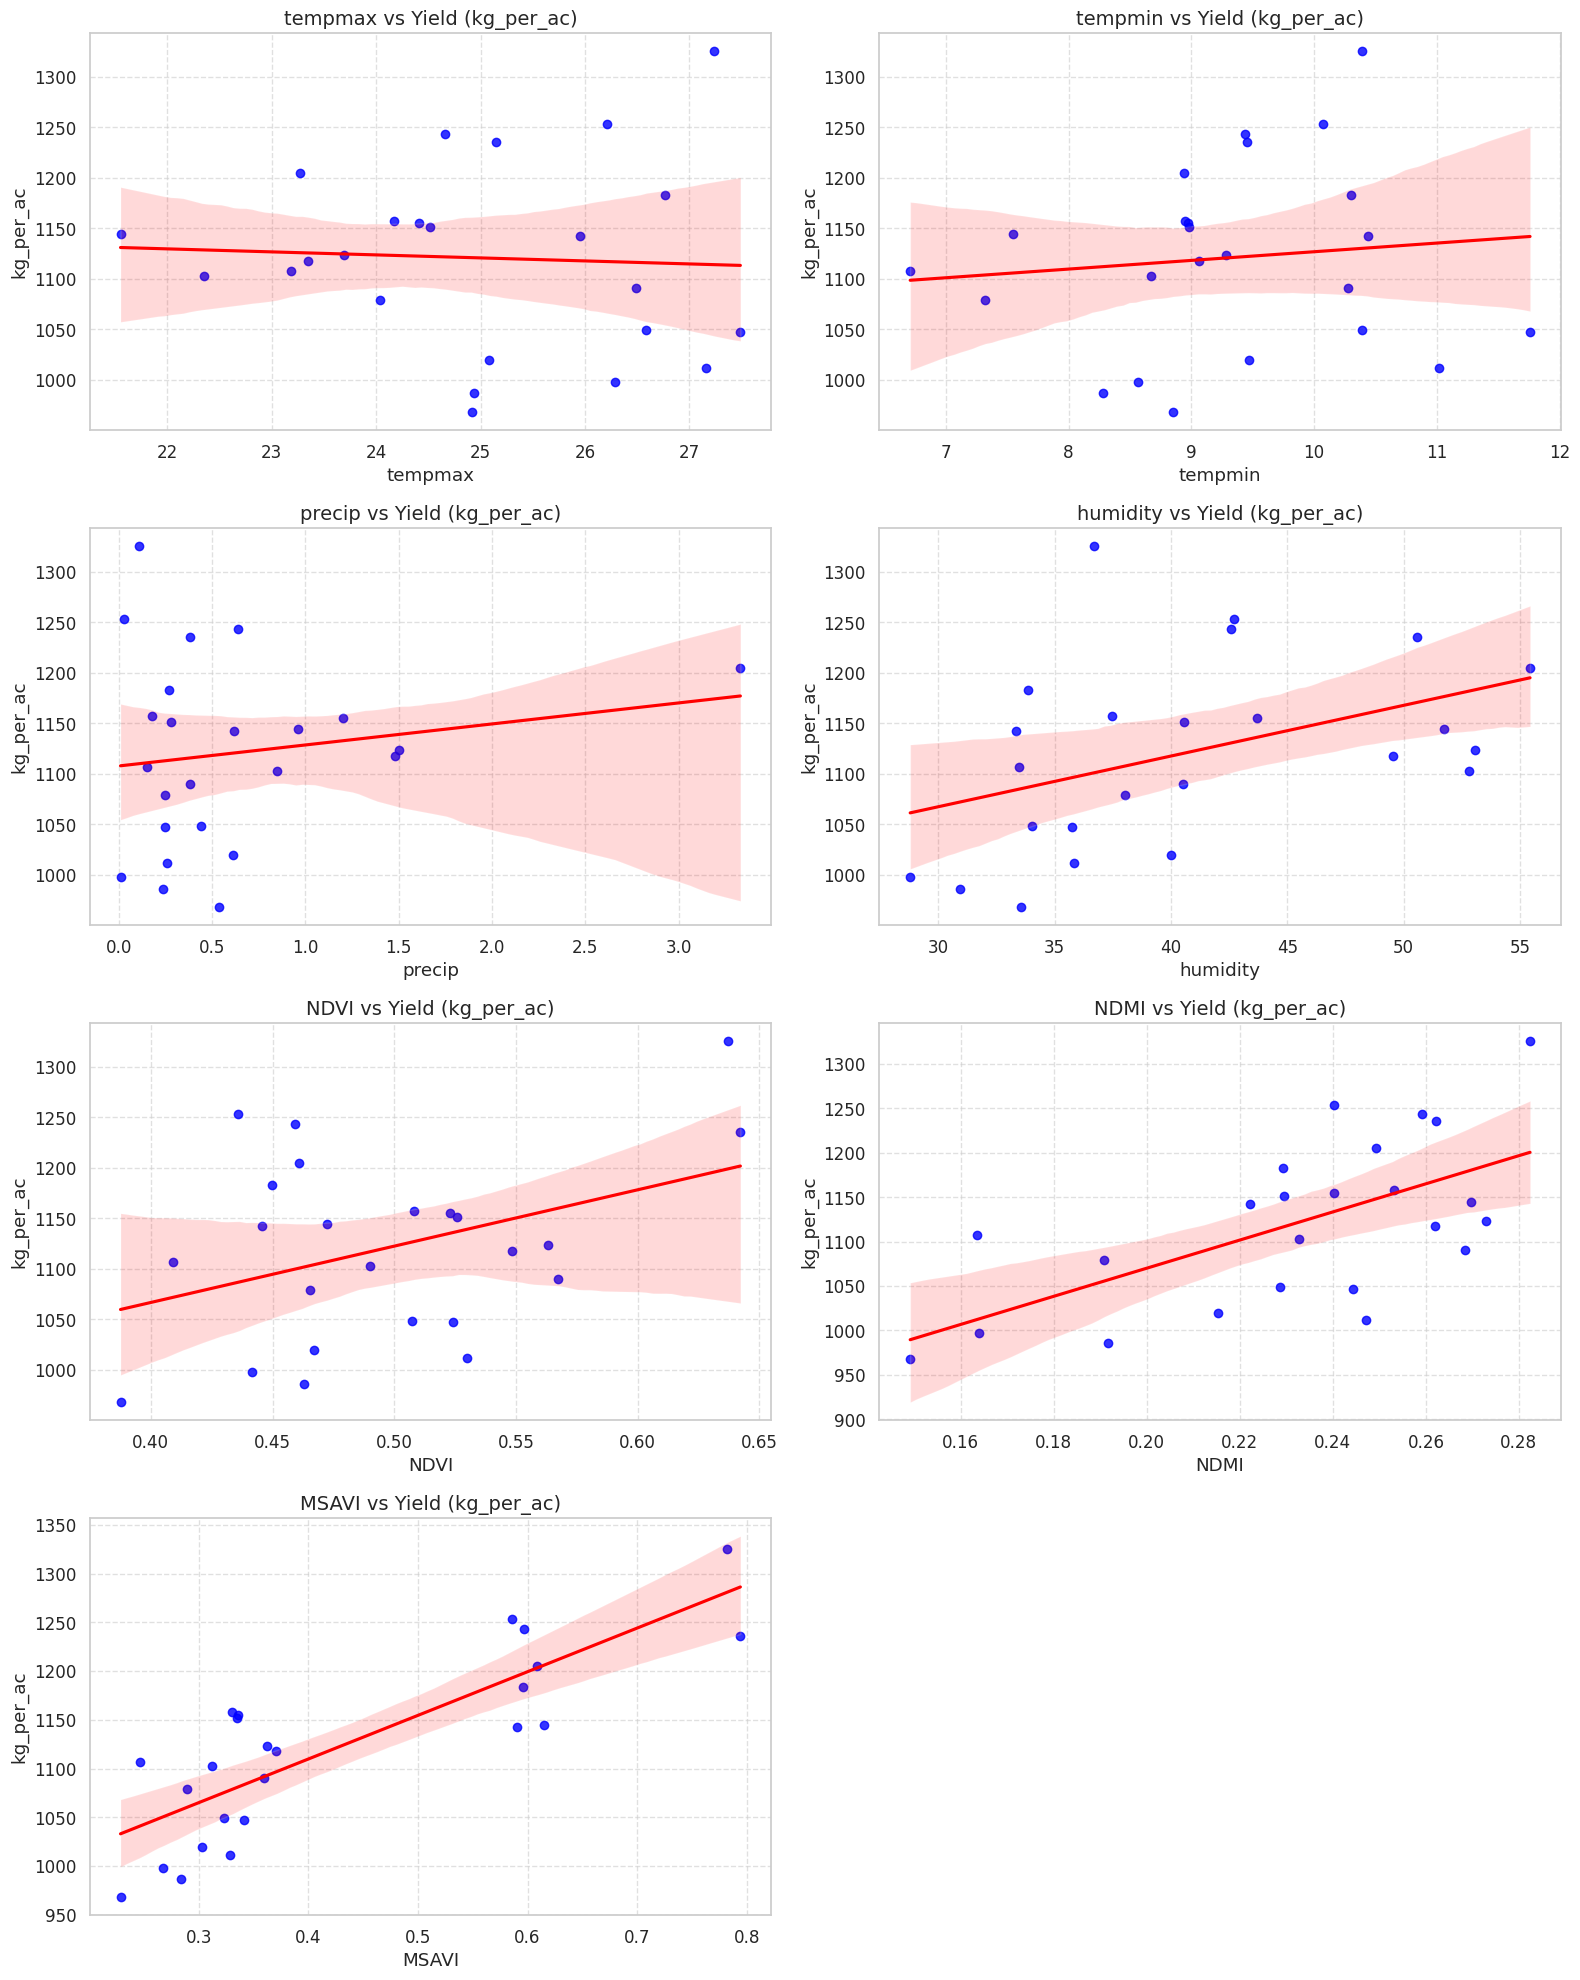

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
merged_data = pd.read_csv('/content/final_merged_weather_yield.csv')

# List of parameters to plot
parameters = ['tempmax', 'tempmin', 'precip', 'humidity', 'NDVI', 'NDMI', 'MSAVI']

# Plotting
fig, axs = plt.subplots(4, 2, figsize=(16, 20))  # 4 rows, 2 columns
axs = axs.flatten()

for i, param in enumerate(parameters):
    sns.regplot(data=merged_data, x=param, y='kg_per_acre', ax=axs[i],
                scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    axs[i].set_title(f'{param} vs Yield (kg_per_ac)', fontsize=14)
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('kg_per_ac')
    axs[i].grid(True, linestyle='--', alpha=0.6)

# Remove empty subplot if any
if len(parameters) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Import libraries
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 2: Load data
df = pd.read_csv('/content/final_merged_weather_yield.csv')

# Step 3: Select features and target
X = df[['tempmax', 'tempmin', 'precip', 'humidity', 'NDVI', 'NDMI', 'MSAVI']]  # Independent variables
y = df['kg_per_acre']  # Dependent variable

# Step 4: Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Handle NaN values if any
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

# Same for testing (optional but safe)
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")


Training data size: (19, 7)
Testing data size: (5, 7)


In [ ]:
# Step 1: Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import joblib

# Step 2: Load the data
df = pd.read_csv('/content/final_merged_weather_yield.csv')

# Step 3: Select features and target
X = df[['tempmax', 'tempmin', 'precip', 'humidity', 'NDVI', 'NDMI', 'MSAVI']]  # Independent variables
y = df['kg_per_acre']  # Dependent variable

# Step 4: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Handle NaN values if any
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

# Step 6: Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 8: Evaluate the model's performance
mae = round(mean_absolute_error(y_test, y_pred), 2)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = round(np.sqrt(mse), 2)
r2_score = round(rf_model.score(X_test, y_test), 2)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2_score}")

# Step 9: Save the trained model
joblib.dump(rf_model, 'yield_prediction_rf_model.pkl')
print("\nModel saved as 'yield_prediction_rf_model.pkl'")



Model Evaluation Metrics:
Mean Absolute Error (MAE): 28.38
Mean Squared Error (MSE): 990.3
Root Mean Squared Error (RMSE): 31.47
R-squared: 0.8

Model saved as 'yield_prediction_rf_model.pkl'


In [ ]:
# Step 1: Import libraries
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import joblib

# Step 2: Load the data
df = pd.read_csv('/content/final_merged_weather_yield.csv')

# Step 3: Select features and target
X = df[['tempmax', 'tempmin', 'precip', 'humidity', 'NDVI', 'NDMI', 'MSAVI']]  # Independent variables
y = df['kg_per_acre']  # Dependent variable

# Step 4: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Handle NaN values if any
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

# Step 6: Initialize and train the Support Vector Machine Regressor
svm_model = SVR(kernel='rbf', C=10, gamma=0.5)  # You can adjust C and gamma as needed
svm_model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Step 8: Evaluate the model's performance
mae = round(mean_absolute_error(y_test, y_pred), 2)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = round(np.sqrt(mse), 2)
r2_score = round(svm_model.score(X_test, y_test), 2)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2_score}")

# Step 9: Save the trained model
joblib.dump(svm_model, 'yield_prediction_svm_model.pkl')
print("\nModel saved as 'yield_prediction_svm_model.pkl'")



Model Evaluation Metrics:
Mean Absolute Error (MAE): 64.21
Mean Squared Error (MSE): 5430.88
Root Mean Squared Error (RMSE): 73.69
R-squared: -0.11

Model saved as 'yield_prediction_svm_model.pkl'


In [ ]:
# Step 1: Import libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import joblib

# Step 2: Load the data
df = pd.read_csv('/content/final_merged_weather_yield.csv')

# Step 3: Select features and target
X = df[['tempmax', 'tempmin', 'precip', 'humidity', 'NDVI', 'NDMI', 'MSAVI']]  # Independent variables
y = df['kg_per_acre']  # Dependent variable

# Step 4: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Handle NaN values if any
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

# Step 6: Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Step 8: Evaluate the model's performance
mae = round(mean_absolute_error(y_test, y_pred), 2)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = round(np.sqrt(mse), 2)
r2_score = round(lr_model.score(X_test, y_test), 2)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2_score}")

# Step 9: Save the trained model
joblib.dump(lr_model, 'yield_prediction_lr_model.pkl')
print("\nModel saved as 'yield_prediction_lr_model.pkl'")



Model Evaluation Metrics:
Mean Absolute Error (MAE): 33.73
Mean Squared Error (MSE): 2273.93
Root Mean Squared Error (RMSE): 47.69
R-squared: 0.53

Model saved as 'yield_prediction_lr_model.pkl'


In [ ]:
# Import libraries
import ee
import geemap

# Authenticate and initialize
ee.Authenticate()
ee.Initialize(project='ee-ansharahmobeen2')

# Load Punjab polygon (Assuming you already have Punjab polygon in your assets or somewhere)
# Example: Load from your assets or FeatureCollection
# punjab = ee.FeatureCollection('users/your_username/punjab')
# If not available, create a dummy point (REMOVE THIS AND LOAD YOUR REAL POLYGON!)
punjab = ee.FeatureCollection('projects/ee-ansharahmobeen2/assets/Export_Output')

# Load Sentinel-2 data
collection = (ee.ImageCollection('COPERNICUS/S2')
    .filterDate('2016-01-15', '2016-03-15')
    .filterBounds(punjab)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
)

# Function to calculate indices
def process_image(image):
    ndvi = image.expression(
        '(nir - red) / (nir + red)', {
            'nir': image.select('B8'),
            'red': image.select('B4')
        }).rename('NDVI')

    ndmi = image.expression(
        '(nir - swir) / (nir + swir)', {
            'nir': image.select('B8'),
            'swir': image.select('B11')
        }).rename('NDMI')

    msavi = image.expression(
        '(2 * nir + 1 - sqrt((2 * nir + 1) * (2 * nir + 1) - 8 * (nir - red))) / 2', {
            'nir': image.select('B8'),
            'red': image.select('B4')
        }).rename('MSAVI')

    return (image.addBands([ndvi, ndmi, msavi])
                .copyProperties(image, image.propertyNames()))

# Apply function over collection
index_collection = collection.map(process_image)

# Take mean over the season
mean_indices = index_collection.mean()

# Load ESA WorldCover 2020 dataset
lulc = ee.Image('ESA/WorldCover/v100/2020')

# Select only cropland areas (class = 40)
cropland = lulc.eq(40)

# Mask non-cropland areas
masked_mean_indices = mean_indices.updateMask(cropland)

# Clip to Punjab
clipped_mean = masked_mean_indices.clip(punjab)

# Calculate average values for each index (ONLY on cropland)
mean_dict = clipped_mean.select(['NDVI', 'NDMI', 'MSAVI']).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=punjab,
    scale=60,
    maxPixels=1e13
)

# Print results
print('Average Values for NDVI, NDMI, MSAVI (Cropland Only):')
print(mean_dict.getInfo())

# Optional: Visualize NDVI
#Map = geemap.Map(center=[31.5, 74], zoom=7)
#Map.addLayer(clipped_mean.select('NDVI'),
 #            {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']},
  #           'Mean NDVI (Cropland Only)')
#Map


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


Average Values for NDVI, NDMI, MSAVI (Cropland Only):
{'MSAVI': 0.590481664843543, 'NDMI': 0.22227798364367427, 'NDVI': 0.4456422909632256}


In [ ]:
import ee
import geemap
import numpy as np
import requests
import joblib

# Authenticate and Initialize
ee.Authenticate()
ee.Initialize(project='ee-ansharahmobeen2')

# 1. Load AOI directly from Earth Engine
aoi = ee.FeatureCollection("projects/ee-ansharahmobeen2/assets/171_cotton")  # 👈 Edit this!

# 2. Calculate vegetation indices
def calculate_indices(aoi):
    start_date = '2024-03-01'
    end_date = '2024-04-15'

    s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterDate(start_date, end_date)
            .filterBounds(aoi)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
         )

    def add_indices(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
        msavi = image.expression(
            '((2 * NIR + 1) - sqrt((2 * NIR + 1)**2 - 8 * (NIR - RED))) / 2', {
                'NIR': image.select('B8'),
                'RED': image.select('B4')
            }).rename('MSAVI')
        return image.addBands([ndvi, ndmi, msavi])

    s2 = s2.map(add_indices)

    median = s2.median()

    ndvi_mean = median.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=10,
        maxPixels=1e9
    ).getInfo()

    ndmi_mean = median.select('NDMI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=10,
        maxPixels=1e9
    ).getInfo()

    msavi_mean = median.select('MSAVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=10,
        maxPixels=1e9
    ).getInfo()

    return {
        'NDVI': ndvi_mean.get('NDVI', 0),
        'NDMI': ndmi_mean.get('NDMI', 0),
        'MSAVI': msavi_mean.get('MSAVI', 0),
    }

print("Calculating vegetation indices...")
indices = calculate_indices(aoi)
print("Indices:", indices)

# 3. Get centroid for NASA POWER weather data
def get_centroid(aoi):
    coords = aoi.geometry().centroid().coordinates().getInfo()
    return coords[1], coords[0]  # lat, lon

lat, lon = get_centroid(aoi)

# 4. NASA POWER Weather API
def get_weather(lat, lon, start_date, end_date):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "start": start_date.replace('-', ''),
        "end": end_date.replace('-', ''),
        "latitude": lat,
        "longitude": lon,
        "community": "AG",
        "parameters": "T2M_MAX,T2M_MIN,PRECTOTCORR,RH2M",
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    data = response.json()

    tempmax = []
    tempmin = []
    prec = []
    humidity = []

    for day in data['properties']['parameter']['T2M_MAX'].values():
        tempmax.append(day)

    for day in data['properties']['parameter']['T2M_MIN'].values():
        tempmin.append(day)

    for day in data['properties']['parameter']['PRECTOTCORR'].values():
        prec.append(day)

    for day in data['properties']['parameter']['RH2M'].values():
        humidity.append(day)

    return {
        'tempmax': np.mean(tempmax),
        'tempmin': np.mean(tempmin),
        'precipitation': np.mean(prec),
        'humidity': np.mean(humidity),
    }


print("Collecting weather data from NASA POWER...")
weather = get_weather(lat, lon, '2024-03-01', '2024-04-15')
print("Weather:", weather)

# 5. Load Random Forest model
model_path = '/content/yield_prediction_rf_model.pkl'  # ✅ already available
rf_model = joblib.load(model_path)

# 6. Predict yield
features = [
    weather['tempmax'],
    weather['tempmin'],
    weather['precipitation'],
    weather['humidity'],
    indices['NDVI'],
    indices['NDMI'],
    indices['MSAVI']
]

# 6. Predict yield
features = [
    weather['tempmax'],
    weather['tempmin'],
    weather['precipitation'],
    weather['humidity'],
    indices['NDVI'],
    indices['NDMI'],
    indices['MSAVI']
]

# 🚨 Check for low vegetation indices before predicting
if indices['NDVI'] < 0.2 or indices['NDMI'] < 0.12 or indices['MSAVI'] < 0.3:
    print("🚫 No significant crop detected. Yield prediction not applicable.")
else:
    X = np.array(features).reshape(1, -1)
    predicted_yield = rf_model.predict(X)[0]
    print(f"🌾 Predicted yield: {predicted_yield:.2f} kg/acre")



Calculating vegetation indices...
Indices: {'NDVI': 0.3943087872061953, 'NDMI': 0.190010097515027, 'MSAVI': 0.5609108894854623}
Weather: {'tempmax': np.float64(34.27804347826087), 'tempmin': np.float64(18.57652173913044), 'precipitation': np.float64(0.19434782608695655), 'humidity': np.float64(28.27478260869565)}
🌾 Predicted yield: 1181.90 kg/acre


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
